by [scheinmensch](https://github.com/scheinmensch)

In this notebook we are going to train our final model, hopefully with excellent results!

In [1]:
# import packages 

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from joblib import dump, load
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# define RSEED
RSEED = 15

# set color schemes
c = ['#cbc0d3', '#efd3d7', '#feeafa', '#dee2ff', '#8e9aaf']
cpal = ['#81B29A', '#89B499', '#91B698', '#99B898', '#A1B997', '#A9BB96', '#B1BD95', '#BABF95', '#C2C194', '#CAC393', '#D2C592', '#DAC691', '#E2C891', '#EACA90', '#F2CC8F']
cpal2 = ['#F2CC8F', '#81B29A']

# set configurations
from sklearn import set_config
set_config(display='diagram')

# suppress warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# load data
bcn = pd.read_csv('../data/df_modelling.csv')

In [3]:
# first look
bcn.head()

,Unnamed: 0,id,name,description,neighborhood_overview,picture_url,host_id,host_name,host_since,host_location,...,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,host_type,suspicious_or_not
0,0,13977576,Habitación individual es Barcelona,Mi alojamiento es bueno para aventureros y via...,NaN,https://a0.muscache.com/pictures/7a6e9767-bd4e...,64903899,Carolina,2016-03-29,"Paris, France",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,f,private,1
1,1,42105584,Habitación M&D,<b>License number</b><br />Exempt,NaN,https://a0.muscache.com/pictures/7342e586-6ea5...,333969184,Midian,2020-02-06,"Barcelona, Spain",...,NaN,NaN,NaN,NaN,NaN,NaN,Exempt,f,private,1
2,2,33727898,Spacious and bright apartment next to Plaza Es...,Hi friends! Welcome to this apartment located ...,The apartment is located in the Eixample quart...,https://a0.muscache.com/pictures/44066458-5997...,251710733,Magda,2019-03-28,NaN,...,4.97,4.97,5.00,5.00,4.83,4.73,HUTB-008684,f,private,1
3,3,44995311,"Single Room, City Center, Private Bathroom",Goya Hostel is a hostel located in the center ...,"The Eixample, which translates as ""widening"" b...",https://a0.muscache.com/pictures/af651bc2-8dff...,363074093,Hostal,2020-08-18,"Barcelona, Spain",...,4.91,4.73,4.91,4.64,4.91,4.73,HUTB-265656,t,commercial,0
4,4,15763812,HABITACIÓN PLAZA ESPAÑA,"Lugares de interés: Poble Espanyol, CaixaForum...",NaN,https://a0.muscache.com/pictures/1bccbbbc-4b78...,101927904,James,2016-10-31,"Barcelona, Spain",...,4.90,4.94,4.96,4.67,4.88,4.60,Exempt,t,private,1


In [4]:
# show how many values are missing per column

missing = pd.DataFrame(bcn.isnull().sum(), columns=["Amount"])
missing['Percentage'] = round((missing['Amount']/bcn.shape[0])*100, 2)
missing[missing['Amount'] != 0]

,Amount,Percentage
name,6,0.05
description,55,0.49
neighborhood_overview,4480,39.51
host_name,2,0.02
host_since,2,0.02
host_location,2502,22.06
host_about,4075,35.93
host_response_time,2048,18.06
host_response_rate,2048,18.06
host_acceptance_rate,1685,14.86


In [5]:
#drop columns with all NaN values
df_bl = bcn.drop(['bathrooms', 'calendar_updated'], axis=1)

In [6]:
#drop some columns which we won't use
df_bl.drop(['Unnamed: 0', 'id', 'name', 'description', 'neighborhood_overview',
       'picture_url', 'host_id', 'host_name', 'host_location',
       'host_about', 'host_thumbnail_url',
       'host_picture_url', 'host_neighbourhood', 'neighbourhood',
       'neighbourhood_cleansed', 'latitude',
       'longitude', 'property_type', 'bathrooms_text', 'beds', 'amenities', 'host_total_listings_count', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'host_verifications' ], axis=1, inplace=True)

In [7]:
#check if those with NaN in many host related columns are always the same two
host_nans = df_bl[df_bl['host_since'].isna()]
host_nans

,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_group_cleansed,room_type,...,bedrooms,price,minimum_nights,maximum_nights,has_availability,number_of_reviews,license,instant_bookable,host_type,suspicious_or_not
3465,NaN,NaN,NaN,NaN,f,NaN,NaN,NaN,Eixample,Private room,...,1.0,$50.00,2,1125,t,1,NaN,f,private,1
11104,NaN,NaN,NaN,NaN,f,NaN,NaN,NaN,Les Corts,Private room,...,1.0,$50.00,1,1125,t,0,NaN,f,private,1


In [8]:
# since they are, we delete them
df_bl=df_bl.dropna(subset=['host_since'])

## change some dtypes

In [9]:
# hoste_since to datetime
df_bl['host_since']= pd.to_datetime(df_bl['host_since'])

In [10]:
# price to float
df_bl['price'] = df_bl['price'].str[1:]
df_bl['price'] = df_bl['price'].str.replace(',','')
df_bl['price'] = pd.to_numeric(df_bl['price'])

In [11]:
# host_response_rate and host_acceptance_rate to float
df_bl['host_response_rate'] = df_bl['host_response_rate'].str.rstrip("%").astype(float)/100
df_bl['host_acceptance_rate'] = df_bl['host_acceptance_rate'].str.rstrip("%").astype(float)/100

In [12]:
# some boolean to 0/1
le = LabelEncoder()
df_bl['host_is_superhost'] = le.fit_transform(df_bl['host_is_superhost'])
df_bl['host_has_profile_pic'] = le.fit_transform(df_bl['host_has_profile_pic'])
df_bl['host_identity_verified'] = le.fit_transform(df_bl['host_identity_verified'])
df_bl['has_availability'] = le.fit_transform(df_bl['has_availability'])
df_bl['instant_bookable'] = le.fit_transform(df_bl['instant_bookable'])

In [13]:
# host_listings_count as int
df_bl['host_listings_count'] = df_bl['host_listings_count'].astype(int)

## train test split

In [14]:
# separate target variable
X = df_bl.drop('suspicious_or_not', axis=1)
y = df_bl['suspicious_or_not']

In [15]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RSEED, stratify = y)

In [16]:
# show sizes of dataframes
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

X_train shape: (9070, 20)
X_test shape: (2268, 20)
y_train shape: (9070,)
y_test shape: (2268,)


## Preprocessing

<AxesSubplot: >

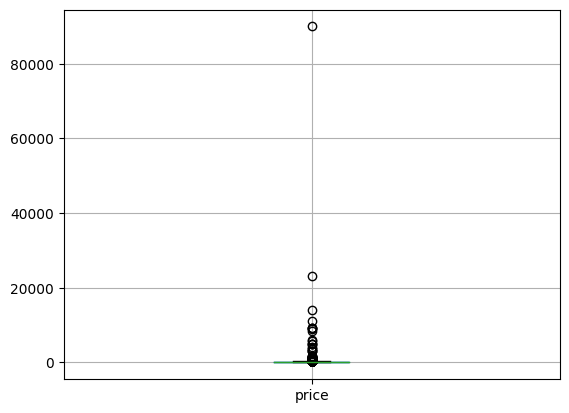

In [17]:
# find outliers in price
X_train.boxplot('price')

<AxesSubplot: >

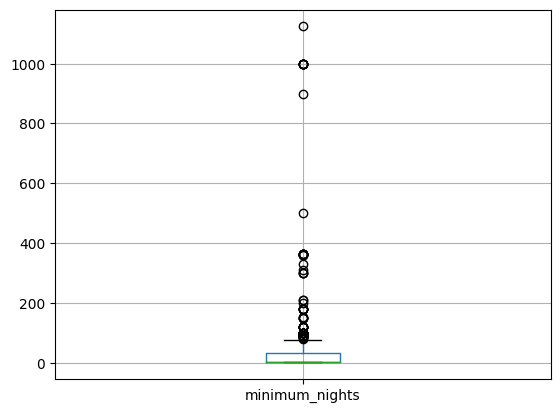

In [18]:
%matplotlib inline

# find outliers in minimum nights
X_train.boxplot('minimum_nights')

In [19]:
# delete price outliers with IQR method

# find IQR of train data
for x in ['price']:
    q75, q25 = np.percentile(X_train.loc[:,x],[75,25])
    intr_qr = q75-q25
    maxp = q75+(1.5*intr_qr)
    minp = q25-(1.5*intr_qr)

# apply on train data    
    X_train.loc[X_train[x] < minp,x] = np.nan
    X_train.loc[X_train[x] > maxp,x] = np.nan
    
# apply on test data    
    X_test.loc[X_test[x] < minp,x] = np.nan
    X_test.loc[X_test[x] > maxp,x] = np.nan

In [20]:
# delete minimum_nights outliers with IQR method

# find IQR of train data
for x in ['minimum_nights']:
    q75, q25 = np.percentile(X_train.loc[:,x],[75,25])
    intr_qr = q75-q25
    maxn = q75+(1.5*intr_qr)
    minn = q25-(1.5*intr_qr)

# apply on train data  
    X_train.loc[X_train[x] < minn,x] = np.nan
    X_train.loc[X_train[x] > maxn,x] = np.nan

# apply on test data    
    X_test.loc[X_test[x] < minn,x] = np.nan
    X_test.loc[X_test[x] > maxn,x] = np.nan

In [21]:
# columns to impute by mean
num_col_mean = ['host_response_rate', 'host_acceptance_rate']

# columns to impute by median
num_col_median = ['bedrooms', 'price', 'minimum_nights', 'maximum_nights']

# categorical columns to impute
cat_col_missing = ['host_response_time']
cat_col_no = ['license']

In [22]:
# create values dict for imputation of missing values
values_dict = {}

# find median of train data and apply on train and test data
for col in num_col_median:
    values_dict[col] = X_train[col].median()
    X_train[col] = X_train[col].fillna(values_dict[col])
    X_test[col] = X_test[col].fillna(values_dict[col])

In [23]:
# find mean of train data and apply on train and test data
for col in num_col_mean:
    values_dict[col] = X_train[col].mean()
    X_train[col] = X_train[col].fillna(values_dict[col])
    X_test[col] = X_test[col].fillna(values_dict[col])

In [24]:
# add new category 'missing' to train and test data
for col in cat_col_missing:
    values_dict[col] = 'missing'
    X_train[col] = X_train[col].fillna(values_dict[col])
    X_test[col] = X_test[col].fillna(values_dict[col])

In [25]:
# add new category 'no' to train and test data
for col in cat_col_no:
    values_dict[col] = 'no'
    X_train[col] = X_train[col].fillna(values_dict[col])
    X_test[col] = X_test[col].fillna(values_dict[col])

## Handle license column

In [26]:
# function to categorize lincenses
def license(license):
    if 'HUTB' in license:
        return 1
    if 'HB' in license:
        return 1
    if 'AJ' in license:
        return 1
    elif 'exempt' in license.lower():
        return 0
    else:
        return 0

In [27]:
# apply function on train and test set
X_train['license'] = X_train.apply(lambda row: license(row['license']), axis=1)
X_test['license'] = X_test.apply(lambda row: license(row['license']), axis=1)

### Building pipelines

**for categorical features**

In [28]:
cat_features = list(X_train.columns[X_train.dtypes==object])
cat_features

['host_response_time',
 'neighbourhood_group_cleansed',
 'room_type',
 'host_type']

In [29]:
cat_pipeline = Pipeline([
    ('1hot', OneHotEncoder(handle_unknown='ignore'))
])

**for numerical features**

In [30]:
num_features = list(X_train.columns[X_train.dtypes!=object])
num_features.remove('host_since')
num_features

['host_response_rate',
 'host_acceptance_rate',
 'host_is_superhost',
 'host_listings_count',
 'host_has_profile_pic',
 'host_identity_verified',
 'accommodates',
 'bedrooms',
 'price',
 'minimum_nights',
 'maximum_nights',
 'has_availability',
 'number_of_reviews',
 'license',
 'instant_bookable']

In [31]:
num_pipeline = Pipeline([
    ('std_scaler', StandardScaler())
])

**preprocessor for features**

In [32]:
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features)
])

# Modelling

Once again our baseline model:
## Logistic Regression

In [33]:
# build pipeline
pipe_logreg_bl = Pipeline([
    ('preprocessor', preprocessor),
    ('logreg', LogisticRegression(max_iter=1000))
])

In [34]:
# cross validate
y_train_predicted_bl = cross_val_predict(pipe_logreg_bl, X_train, y_train, cv=5)

In [35]:
# print scores
print('Cross validation scores:')
print('-------------------------')
print("Accuracy: {:.2f}".format(accuracy_score(y_train, y_train_predicted_bl)))
print("Recall: {:.2f}".format(recall_score(y_train, y_train_predicted_bl)))
print("Precision: {:.2f}".format(precision_score(y_train, y_train_predicted_bl)))

Cross validation scores:
-------------------------
Accuracy: 0.87
Recall: 0.84
Precision: 0.87


#### Hyperparameter tuning

In [36]:
# define parameters to test
param_logreg_bl = {'logreg__penalty':('l1','l2'),
                'logreg__C': [0.001, 0.01, 0.1, 1, 10],
                'logreg__solver': ['liblinear', 'lbfgs', 'sag'],
               }

#define grid search
grid_logreg_bl = GridSearchCV(pipe_logreg_bl, param_grid=param_logreg_bl, cv=5, scoring='accuracy', 
                           verbose=5, n_jobs=-1)

In [37]:
# run grid search
grid_logreg_bl.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('std_scaler',
                                                                                          StandardScaler())]),
                                                                         ['host_response_rate',
                                                                          'host_acceptance_rate',
                                                                          'host_is_superhost',
                                                                          'host_listings_count',
                                                                          'host_has_profile_pic',
                                                                          'host_identity_verified',
                                                                          'accommodates',
                                                                          'bedrooms',
                                                                          'price',
                                                                          'minimum_nights',
                                                                          'maximum_nights...
                                                                         Pipeline(steps=[('1hot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['host_response_time',
                                                                          'neighbourhood_group_cleansed',
                                                                          'room_type',
                                                                          'host_type'])])),
                                       ('logreg',
                                        LogisticRegression(max_iter=1000))]),
             n_jobs=-1,
             param_grid={'logreg__C': [0.001, 0.01, 0.1, 1, 10],
                         'logreg__penalty': ('l1', 'l2'),
                         'logreg__solver': ['liblinear', 'lbfgs', 'sag']},
             scoring='accuracy', verbose=5)

In [38]:
# print best score and parameters
print('Best score:\n{:.2f}'.format(grid_logreg_bl.best_score_))
print("Best parameters:\n{}".format(grid_logreg_bl.best_params_))

Best score:
0.80
Best parameters:
{'logreg__C': 0.001, 'logreg__penalty': 'l1', 'logreg__solver': 'liblinear'}


In [39]:
# save model with best parameters
baselinemodel = grid_logreg_bl.best_estimator_
baselinemodel

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('std_scaler',
                                                                   StandardScaler())]),
                                                  ['host_response_rate',
                                                   'host_acceptance_rate',
                                                   'host_is_superhost',
                                                   'host_listings_count',
                                                   'host_has_profile_pic',
                                                   'host_identity_verified',
                                                   'accommodates', 'bedrooms',
                                                   'price', 'minimum_nights',
                                                   'maximum_nights',
                                                   'has_availability',
                                                   'number_of_reviews',
                                                   'license',
                                                   'instant_bookable']),
                                                 ('cat',
                                                  Pipeline(steps=[('1hot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['host_response_time',
                                                   'neighbourhood_group_cleansed',
                                                   'room_type',
                                                   'host_type'])])),
                ('logreg',
                 LogisticRegression(C=0.001, max_iter=1000, penalty='l1',
                                    solver='liblinear'))])

In [40]:
# apply model on test data
y_test_predicted_bl = baselinemodel.predict(X_test)
print("Accuracy: {:.2f}".format(accuracy_score(y_test, y_test_predicted_bl)))
print("Recall: {:.2f}".format(recall_score(y_test, y_test_predicted_bl)))
print("Precision: {:.2f}".format(precision_score(y_test, y_test_predicted_bl)))

Accuracy: 0.80
Recall: 0.89
Precision: 0.73


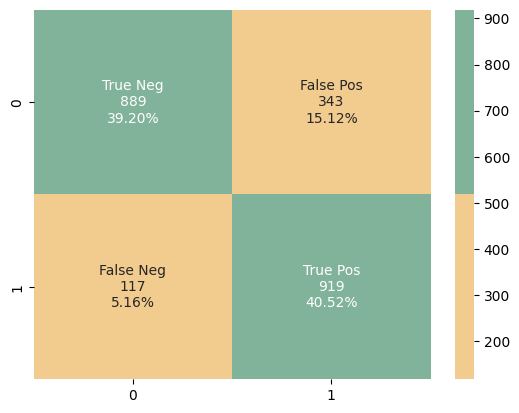

In [41]:
# plot confusion matrix
%matplotlib inline
cfm_bl = confusion_matrix(y_test, y_test_predicted_bl)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cfm_bl.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cfm_bl.flatten()/np.sum(cfm_bl)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cfm_bl, annot=labels, fmt='', cmap=cpal2);

## Random Forest

In [41]:
# build pipeline
pipe_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('randfor', RandomForestClassifier(random_state=RSEED))
])

#cross validate
y_train_predicted_rf = cross_val_predict(pipe_rf, X_train, y_train, cv=5)

#print scores
print('Cross validation scores:')
print('-------------------------')
print("Accuracy: {:.2f}".format(accuracy_score(y_train, y_train_predicted_rf)))
print("Recall: {:.2f}".format(recall_score(y_train, y_train_predicted_rf)))
print("Precision: {:.2f}".format(precision_score(y_train, y_train_predicted_rf)))

Cross validation scores:
-------------------------
Accuracy: 0.98
Recall: 0.99
Precision: 0.97


#### Hyperparameter tuning

In [43]:
# define parameters to test
param_rf_all = {'randfor__n_estimators':[100, 500, 1000, 1500, 2000],
                'randfor__min_samples_split': [2, 5, 10, 15, 20],
                'randfor__max_depth': [10,20,50,80,100],
                'randfor__max_features': ['auto', 'sqrt'],
                'randfor__min_samples_leaf' : [1,2,4],
                'randfor__bootstrap': [True, False],
              }

In [44]:
# save best parameters found in grid search
param_rf_best = {'randfor__n_estimators':[1500],
                'randfor__min_samples_split': [2],
                'randfor__max_depth': [50],
                'randfor__max_features': ['auto'],
                'randfor__min_samples_leaf' : [1],
                'randfor__bootstrap': [False],
             }

In [45]:
# define grid search (now only with the best parameters)
grid_rf = GridSearchCV(pipe_rf, param_grid=param_rf_best, cv=5, scoring='accuracy', 
                           verbose=5, n_jobs=-1)

# run grid search
grid_rf.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('std_scaler',
                                                                                          StandardScaler())]),
                                                                         ['host_response_rate',
                                                                          'host_acceptance_rate',
                                                                          'host_is_superhost',
                                                                          'host_listings_count',
                                                                          'host_has_profile_pic',
                                                                          'host_identity_verified',
                                                                          'accommodates',
                                                                          'bedrooms',
                                                                          'price',
                                                                          'minimum_nights',
                                                                          'maximum_nights...
                                                                          'neighbourhood_group_cleansed',
                                                                          'room_type',
                                                                          'host_type'])])),
                                       ('randfor',
                                        RandomForestClassifier(random_state=15))]),
             n_jobs=-1,
             param_grid={'randfor__bootstrap': [False],
                         'randfor__max_depth': [50],
                         'randfor__max_features': ['auto'],
                         'randfor__min_samples_leaf': [1],
                         'randfor__min_samples_split': [2],
                         'randfor__n_estimators': [1500]},
             scoring='accuracy', verbose=5)

In [46]:
# print best score and best parameters
print('Best score:\n{:.2f}'.format(grid_rf.best_score_))
print("Best parameters:\n{}".format(grid_rf.best_params_))

Best score:
0.99
Best parameters:
{'randfor__bootstrap': False, 'randfor__max_depth': 50, 'randfor__max_features': 'auto', 'randfor__min_samples_leaf': 1, 'randfor__min_samples_split': 2, 'randfor__n_estimators': 1500}


In [47]:
# save model with best parameters in a variable
randomforest = grid_rf.best_estimator_
randomforest

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('std_scaler',
                                                                   StandardScaler())]),
                                                  ['host_response_rate',
                                                   'host_acceptance_rate',
                                                   'host_is_superhost',
                                                   'host_listings_count',
                                                   'host_has_profile_pic',
                                                   'host_identity_verified',
                                                   'accommodates', 'bedrooms',
                                                   'price', 'minimum_nights',
                                                   'maximum_nights',
                                                   'has_availability',
                                                   'number_of_reviews',
                                                   'license',
                                                   'instant_bookable']),
                                                 ('cat',
                                                  Pipeline(steps=[('1hot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['host_response_time',
                                                   'neighbourhood_group_cleansed',
                                                   'room_type',
                                                   'host_type'])])),
                ('randfor',
                 RandomForestClassifier(bootstrap=False, max_depth=50,
                                        n_estimators=1500, random_state=15))])

In [48]:
y_test_predicted_rf_final = randomforest.predict(X_test)
print("Accuracy: {:.2f}".format(accuracy_score(y_test, y_test_predicted_rf_final)))
print("Recall: {:.2f}".format(recall_score(y_test, y_test_predicted_rf_final)))
print("Precision: {:.2f}".format(precision_score(y_test, y_test_predicted_rf_final)))

Accuracy: 0.99
Recall: 0.99
Precision: 0.98


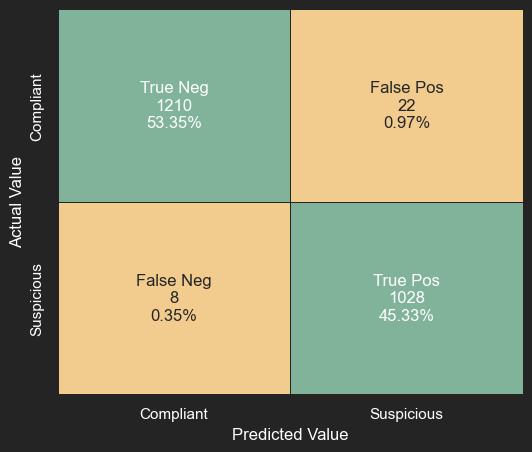

In [83]:
%matplotlib inline
cfm_rf_final = confusion_matrix(y_test, y_test_predicted_rf_final)
fig = plt.figure()
fig.set_size_inches(6,5)
sns.set(rc={'axes.facecolor':'#242424','figure.facecolor':'#242424','text.color':'white'})
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cfm_rf_final.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cfm_rf_final.flatten()/np.sum(cfm_rf_final)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
ax = plt.axes()
x_axis_labels = ['Compliant', 'Suspicious'] 
y_axis_labels = ['Compliant', 'Suspicious'] 
sns.heatmap(cfm_rf_final, annot=labels, fmt='', cmap=cpal2, xticklabels=x_axis_labels, yticklabels=y_axis_labels, linewidth=.5, cbar = False, linecolor='#242424')
# ax.set_title('Confusion Matrix')
xlabel = plt.xlabel('Predicted Value')
ylabel = plt.ylabel('Actual Value')
xlabel.set_color("white")
ylabel.set_color("white")
ax.tick_params(colors='white')
plt.show();

#### feature importance

In [49]:
# save pipeline with model in a variable
pipe_rf_final = Pipeline([
    ('preprocessor', preprocessor),
    ('randfor', RandomForestClassifier(n_estimators = 1500, min_samples_split = 2, max_depth = 50, max_features = 'auto', min_samples_leaf = 1, bootstrap = False, random_state=RSEED))
])

In [50]:
# fit
pipe_rf_final.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('std_scaler',
                                                                   StandardScaler())]),
                                                  ['host_response_rate',
                                                   'host_acceptance_rate',
                                                   'host_is_superhost',
                                                   'host_listings_count',
                                                   'host_has_profile_pic',
                                                   'host_identity_verified',
                                                   'accommodates', 'bedrooms',
                                                   'price', 'minimum_nights',
                                                   'maximum_nights',
                                                   'has_availability',
                                                   'number_of_reviews',
                                                   'license',
                                                   'instant_bookable']),
                                                 ('cat',
                                                  Pipeline(steps=[('1hot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['host_response_time',
                                                   'neighbourhood_group_cleansed',
                                                   'room_type',
                                                   'host_type'])])),
                ('randfor',
                 RandomForestClassifier(bootstrap=False, max_depth=50,
                                        n_estimators=1500, random_state=15))])

In [51]:
# print scores
y_test_predicted_rf_final = pipe_rf_final.predict(X_test)
print("Accuracy: {:.2f}".format(accuracy_score(y_test, y_test_predicted_rf_final)))
print("Recall: {:.2f}".format(recall_score(y_test, y_test_predicted_rf_final)))
print("Precision: {:.2f}".format(precision_score(y_test, y_test_predicted_rf_final)))

Accuracy: 0.99
Recall: 0.99
Precision: 0.98


In [52]:
pipe_rf_final.steps

[('preprocessor',
  ColumnTransformer(transformers=[('num',
                                   Pipeline(steps=[('std_scaler',
                                                    StandardScaler())]),
                                   ['host_response_rate', 'host_acceptance_rate',
                                    'host_is_superhost', 'host_listings_count',
                                    'host_has_profile_pic',
                                    'host_identity_verified', 'accommodates',
                                    'bedrooms', 'price', 'minimum_nights',
                                    'maximum_nights', 'has_availability',
                                    'number_of_reviews', 'license',
                                    'instant_bookable']),
                                  ('cat',
                                   Pipeline(steps=[('1hot',
                                                    OneHotEncoder(handle_unknown='ignore'))]),
                             

In [53]:
pipe_rf_final.steps[1][1].feature_importances_

array([0.01951348, 0.02408476, 0.00720364, 0.10766863, 0.00069156,
       0.00277516, 0.02120939, 0.01028518, 0.05291788, 0.19684546,
       0.01893237, 0.00040881, 0.03664728, 0.19752961, 0.00576861,
       0.00046767, 0.01048957, 0.00319581, 0.00346809, 0.00625768,
       0.00500874, 0.00343849, 0.00227532, 0.00107269, 0.00123268,
       0.00075177, 0.00072106, 0.00216054, 0.00241418, 0.00167182,
       0.02285869, 0.00048254, 0.03060983, 0.00057545, 0.09583038,
       0.10253517])

In [54]:
pipe_rf_final.steps

[('preprocessor',
  ColumnTransformer(transformers=[('num',
                                   Pipeline(steps=[('std_scaler',
                                                    StandardScaler())]),
                                   ['host_response_rate', 'host_acceptance_rate',
                                    'host_is_superhost', 'host_listings_count',
                                    'host_has_profile_pic',
                                    'host_identity_verified', 'accommodates',
                                    'bedrooms', 'price', 'minimum_nights',
                                    'maximum_nights', 'has_availability',
                                    'number_of_reviews', 'license',
                                    'instant_bookable']),
                                  ('cat',
                                   Pipeline(steps=[('1hot',
                                                    OneHotEncoder(handle_unknown='ignore'))]),
                             

In [55]:
pipe_rf_final[0].output_indices_

{'num': slice(0, 15, None),
 'cat': slice(15, 36, None),
 'remainder': slice(0, 0, None)}

In [56]:
encoded_cat_features = pipe_rf_final['preprocessor'].transformers_[1][1]\
    ['1hot'].get_feature_names_out(cat_features)

In [57]:
feature_names = np.insert(encoded_cat_features,0, num_features)

<BarContainer object of 36 artists>

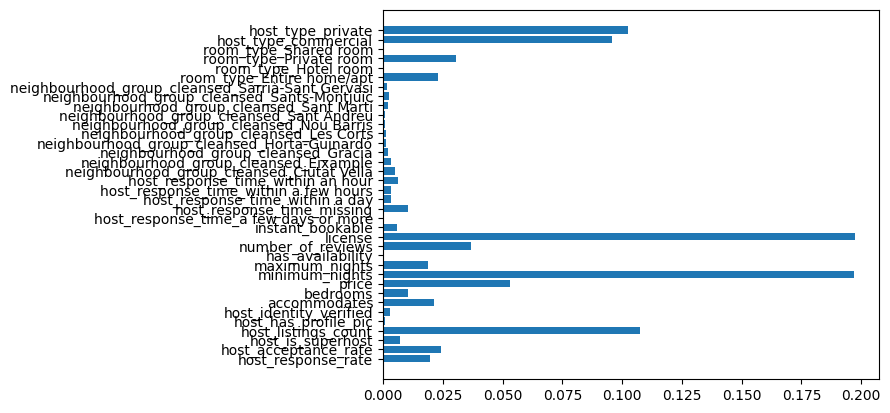

In [58]:
plt.barh(feature_names, pipe_rf_final.steps[1][1].feature_importances_)

#### Error Analysis

In [59]:
index = X_test.index

In [60]:
yhats = pd.Series(y_test_predicted_rf_final, name = 'y_hats', index=index)

In [61]:
X_test_err_an = pd.concat([X_test, yhats, y_test], axis=1)

In [62]:
def error_analysis(row):
    if row['suspicious_or_not'] == 0 and row['y_hats'] == 0:
        return "TN"
    if row['suspicious_or_not'] == 1 and row['y_hats'] == 1:
        return "TP"
    if row['suspicious_or_not'] == 0 and row['y_hats'] == 1:
        return "FP"
    if row['suspicious_or_not'] == 1 and row['y_hats'] == 0:
        return "FN"

In [63]:
X_test_err_an['error_analysis'] = X_test_err_an.apply(lambda row: error_analysis(row), axis=1)

In [64]:
TP = X_test_err_an.loc[(X_test_err_an.error_analysis == "TP")]
FN = X_test_err_an.loc[(X_test_err_an.error_analysis == "FN")]
FP = X_test_err_an.loc[(X_test_err_an.error_analysis == "FP")]
TN = X_test_err_an.loc[(X_test_err_an.error_analysis == "TN")]

In [65]:
FP[['host_type', 'host_listings_count','minimum_nights', 'license', 'suspicious_or_not', 'y_hats', 'error_analysis' ]].head(30)

,host_type,host_listings_count,minimum_nights,license,suspicious_or_not,y_hats,error_analysis
8924,private,1,3.0,0,0,1,FP
4208,private,6,3.0,1,0,1,FP
1505,private,2,3.0,0,0,1,FP
4103,private,1,3.0,0,0,1,FP
6898,private,6,2.0,1,0,1,FP
3822,commercial,45,3.0,0,0,1,FP
5118,commercial,1,3.0,0,0,1,FP
7018,private,8,1.0,1,0,1,FP
8619,private,1,3.0,0,0,1,FP
4968,private,1,3.0,0,0,1,FP


In [66]:
FN[['host_type', 'host_listings_count','minimum_nights', 'license', 'suspicious_or_not', 'y_hats', 'error_analysis' ]].head(30)

,host_type,host_listings_count,minimum_nights,license,suspicious_or_not,y_hats,error_analysis
8556,private,4,2.0,1,1,0,FN
7611,private,4,3.0,1,1,0,FN
3972,private,5,2.0,1,1,0,FN
4445,private,5,2.0,1,1,0,FN
837,private,8,3.0,1,1,0,FN
4442,private,4,3.0,1,1,0,FN
10269,private,4,2.0,1,1,0,FN
2458,private,5,2.0,1,1,0,FN


Now we try tome more algorithms to see how they perform
## XGB Classifier

In [67]:
pipe_xgb = Pipeline([
    ('preprocessor', preprocessor),
    ('xgb', XGBClassifier(random_state=RSEED))
])

y_train_predicted_xgb = cross_val_predict(pipe_xgb, X_train, y_train, cv=5)

print('Cross validation scores:')
print('-------------------------')
print("Accuracy: {:.2f}".format(accuracy_score(y_train, y_train_predicted_rf)))
print("Recall: {:.2f}".format(recall_score(y_train, y_train_predicted_rf)))
print("Precision: {:.2f}".format(precision_score(y_train, y_train_predicted_rf)))

Cross validation scores:
-------------------------
Accuracy: 0.98
Recall: 0.99
Precision: 0.97


In [68]:
param_xgb_all = {
    "xgb__learning_rate" : [0.05,0.15,0.30],
    "xgb__max_depth" : [ 3, 6, 10, 15],
    "xgb__min_child_weight" : [ 1, 3, 5, 7 ],
    "xgb__gamma": [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
    "xgb__colsample_bytree" : [ 0.3,  0.5 , 0.7 ],
    "xgb__subsample" : [0.5, 1],
    "xgb__scale_pos_weight" : [1, 2]
    }

In [69]:
param_xgb_best = {
    "xgb__learning_rate" : [0.05],
    "xgb__max_depth" : [10],
    "xgb__min_child_weight" : [5],
    "xgb__gamma": [ 0.1],
    "xgb__colsample_bytree" : [0.5],
    "xgb__subsample" : [0.5],
    "xgb__scale_pos_weight" : [1]
    }

In [70]:
grid_xgb = GridSearchCV(pipe_xgb, param_grid=param_xgb_best, cv=5, scoring='accuracy', 
                           verbose=5, n_jobs=-1)

grid_xgb.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('std_scaler',
                                                                                          StandardScaler())]),
                                                                         ['host_response_rate',
                                                                          'host_acceptance_rate',
                                                                          'host_is_superhost',
                                                                          'host_listings_count',
                                                                          'host_has_profile_pic',
                                                                          'host_identity_verified',
                                                                          'accommodates',
                                                                          'bedrooms',
                                                                          'price',
                                                                          'minimum_nights',
                                                                          'maximum_nights...
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      n_estimators=100,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=15, ...))]),
             n_jobs=-1,
             param_grid={'xgb__colsample_bytree': [0.5], 'xgb__gamma': [0.1],
                         'xgb__learning_rate': [0.05], 'xgb__max_depth': [10],
                         'xgb__min_child_weight': [5],
                         'xgb__scale_pos_weight': [1],
                         'xgb__subsample': [0.5]},
             scoring='accuracy', verbose=5)

In [71]:
print('Best score:\n{:.2f}'.format(grid_xgb.best_score_))
print("Best parameters:\n{}".format(grid_xgb.best_params_))

Best score:
0.98
Best parameters:
{'xgb__colsample_bytree': 0.5, 'xgb__gamma': 0.1, 'xgb__learning_rate': 0.05, 'xgb__max_depth': 10, 'xgb__min_child_weight': 5, 'xgb__scale_pos_weight': 1, 'xgb__subsample': 0.5}


In [72]:
XGBOOST = grid_xgb.best_estimator_
XGBOOST

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('std_scaler',
                                                                   StandardScaler())]),
                                                  ['host_response_rate',
                                                   'host_acceptance_rate',
                                                   'host_is_superhost',
                                                   'host_listings_count',
                                                   'host_has_profile_pic',
                                                   'host_identity_verified',
                                                   'accommodates', 'bedrooms',
                                                   'price', 'minimum_nights',
                                                   'maximum_nights',
                                                   'has_availability',
                                                   'number...
                               feature_types=None, gamma=0.1, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=10, max_leaves=None,
                               min_child_weight=5, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=15, ...))])

In [73]:
y_test_predicted_xgb = XGBOOST.predict(X_test)
print("Accuracy: {:.2f}".format(accuracy_score(y_test, y_test_predicted_xgb)))
print("Recall: {:.2f}".format(recall_score(y_test, y_test_predicted_xgb)))
print("Precision: {:.2f}".format(precision_score(y_test, y_test_predicted_xgb)))

Accuracy: 0.98
Recall: 0.98
Precision: 0.98


## KNN

In [74]:
pipe_knn = Pipeline([
    ('preprocessor', preprocessor),
    ('knn', KNeighborsClassifier(n_neighbors=5, metric='euclidean'))
])

y_train_predicted_knn = cross_val_predict(pipe_knn, X_train, y_train, cv=5)

print('Cross validation scores:')
print('-------------------------')
print("Accuracy: {:.2f}".format(accuracy_score(y_train, y_train_predicted_knn)))
print("Recall: {:.2f}".format(recall_score(y_train, y_train_predicted_knn)))
print("Precision: {:.2f}".format(precision_score(y_train, y_train_predicted_knn)))

Cross validation scores:
-------------------------
Accuracy: 0.87
Recall: 0.88
Precision: 0.85


## Decision Tree

In [75]:
pipe_tree = Pipeline([
    ('preprocessor', preprocessor),
    ('tree', DecisionTreeClassifier(criterion='gini', max_depth=15, random_state=RSEED))
])

y_train_predicted_tree = cross_val_predict(pipe_tree, X_train, y_train, cv=5)

print('Cross validation scores:')
print('-------------------------')
print("Accuracy: {:.2f}".format(accuracy_score(y_train, y_train_predicted_tree)))
print("Recall: {:.2f}".format(recall_score(y_train, y_train_predicted_tree)))
print("Precision: {:.2f}".format(precision_score(y_train, y_train_predicted_tree)))

Cross validation scores:
-------------------------
Accuracy: 0.98
Recall: 0.98
Precision: 0.98


In [76]:
param_tree_all = {'tree__criterion':['gini', 'entropy'],
                'tree__max_depth':[2,4,6,8,10,12]
              }

In [77]:
param_tree_best = {'tree__criterion':['entropy'],
                'tree__max_depth':[6]
              }

In [78]:
grid_tree = GridSearchCV(pipe_tree, param_grid=param_tree_all, cv=5, scoring='accuracy', 
                           verbose=5, n_jobs=-1)

grid_tree.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('std_scaler',
                                                                                          StandardScaler())]),
                                                                         ['host_response_rate',
                                                                          'host_acceptance_rate',
                                                                          'host_is_superhost',
                                                                          'host_listings_count',
                                                                          'host_has_profile_pic',
                                                                          'host_identity_verified',
                                                                          'accommodates',
                                                                          'bedrooms',
                                                                          'price',
                                                                          'minimum_nights',
                                                                          'maximum_nights...
                                                                          'instant_bookable']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('1hot',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['host_response_time',
                                                                          'neighbourhood_group_cleansed',
                                                                          'room_type',
                                                                          'host_type'])])),
                                       ('tree',
                                        DecisionTreeClassifier(max_depth=15,
                                                               random_state=15))]),
             n_jobs=-1,
             param_grid={'tree__criterion': ['gini', 'entropy'],
                         'tree__max_depth': [2, 4, 6, 8, 10, 12]},
             scoring='accuracy', verbose=5)

In [79]:
print('Best score:\n{:.2f}'.format(grid_tree.best_score_))
print("Best parameters:\n{}".format(grid_tree.best_params_))

Best score:
0.98
Best parameters:
{'tree__criterion': 'gini', 'tree__max_depth': 12}


In [80]:
Tree = grid_tree.best_estimator_
Tree

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('std_scaler',
                                                                   StandardScaler())]),
                                                  ['host_response_rate',
                                                   'host_acceptance_rate',
                                                   'host_is_superhost',
                                                   'host_listings_count',
                                                   'host_has_profile_pic',
                                                   'host_identity_verified',
                                                   'accommodates', 'bedrooms',
                                                   'price', 'minimum_nights',
                                                   'maximum_nights',
                                                   'has_availability',
                                                   'number_of_reviews',
                                                   'license',
                                                   'instant_bookable']),
                                                 ('cat',
                                                  Pipeline(steps=[('1hot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['host_response_time',
                                                   'neighbourhood_group_cleansed',
                                                   'room_type',
                                                   'host_type'])])),
                ('tree',
                 DecisionTreeClassifier(max_depth=12, random_state=15))])

In [81]:
y_test_predicted_tree = Tree.predict(X_test)
print("Accuracy: {:.2f}".format(accuracy_score(y_test, y_test_predicted_tree)))
print("Recall: {:.2f}".format(recall_score(y_test, y_test_predicted_tree)))
print("Precision: {:.2f}".format(precision_score(y_test, y_test_predicted_tree)))

Accuracy: 0.98
Recall: 0.98
Precision: 0.98


## Conclusion

The best model is the random forest with an accuracy of 99%.
In the error analysis we found out that outliers and the way we handled them produce these errors. But since overall the new preprocessing incl. outlier handling improved our model a lot we accept these errors for now